In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

In [78]:
df = pd.read_csv('../data/energy_consumption_dataset.csv')

In [79]:
df.head()

,Month,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption
0,1,0,Saturday,No,25.139433,43.431581,1565.693999,5,On,Off,2.774699,75.364373
1,1,1,Saturday,No,27.731651,54.225919,1411.064918,1,On,On,21.831384,83.401855
2,1,2,Saturday,No,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,78.270888
3,1,3,Saturday,No,20.080469,50.371637,1452.316318,1,Off,On,8.623447,56.519850
4,1,4,Saturday,No,23.097359,51.401421,1094.130359,9,On,Off,3.071969,70.811732


In [80]:
print('Shape of the dataset:', df.shape)

Shape of the dataset: (5000, 12)


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              5000 non-null   int64  
 1   Hour               5000 non-null   int64  
 2   DayOfWeek          5000 non-null   object 
 3   Holiday            5000 non-null   object 
 4   Temperature        5000 non-null   float64
 5   Humidity           5000 non-null   float64
 6   SquareFootage      5000 non-null   float64
 7   Occupancy          5000 non-null   int64  
 8   HVACUsage          5000 non-null   object 
 9   LightingUsage      5000 non-null   object 
 10  RenewableEnergy    5000 non-null   float64
 11  EnergyConsumption  5000 non-null   float64
dtypes: float64(5), int64(3), object(4)
memory usage: 468.9+ KB


In [82]:
df.describe()

,Month,Hour,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,6.251200,11.556000,24.946823,45.478146,1507.403201,4.576000,15.201195,76.794919
std,3.588687,6.888306,3.041678,8.972690,293.147209,2.906185,9.157038,9.231573
min,1.000000,0.000000,20.007565,30.015975,1000.512661,0.000000,0.006642,53.263278
25%,3.000000,6.000000,22.453790,38.111104,1253.906598,2.000000,7.477928,70.419588
50%,6.000000,11.000000,24.831846,45.793124,1513.581105,5.000000,15.343830,76.696267
75%,9.000000,18.000000,27.427281,52.696651,1754.846457,7.000000,22.889997,83.246274
max,12.000000,23.000000,29.998671,59.969085,1999.982252,9.000000,29.965327,99.201120


In [83]:
df.duplicated().sum()

np.int64(0)

In [84]:
df.isnull().sum()

Month                0
Hour                 0
DayOfWeek            0
Holiday              0
Temperature          0
Humidity             0
SquareFootage        0
Occupancy            0
HVACUsage            0
LightingUsage        0
RenewableEnergy      0
EnergyConsumption    0
dtype: int64

# 1. EDA

In [85]:
monthly_average_consumption = df.groupby('Month')['EnergyConsumption'].mean().reset_index()

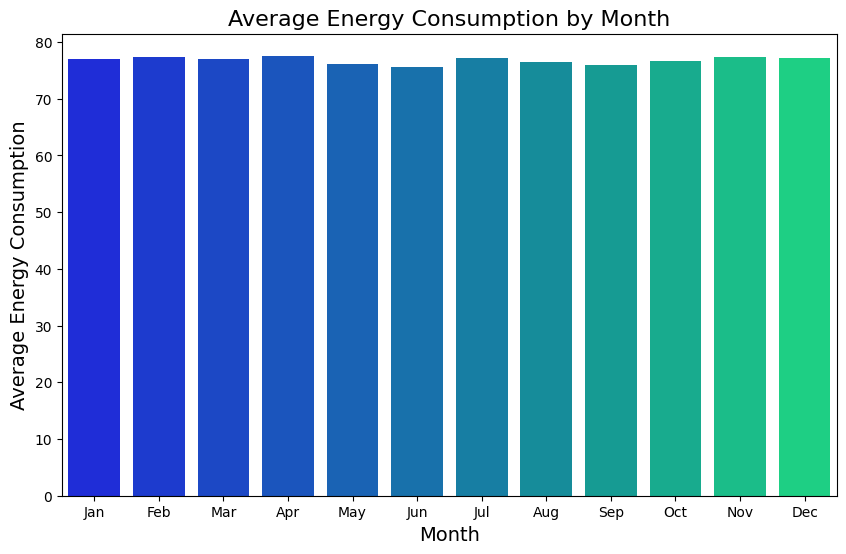

In [86]:
#bar chart
plt.figure(figsize=(10,6))
sns.barplot(x='Month', y= 'EnergyConsumption', data = monthly_average_consumption, palette='winter')
plt.title('Average Energy Consumption by Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Energy Consumption', fontsize=14)
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

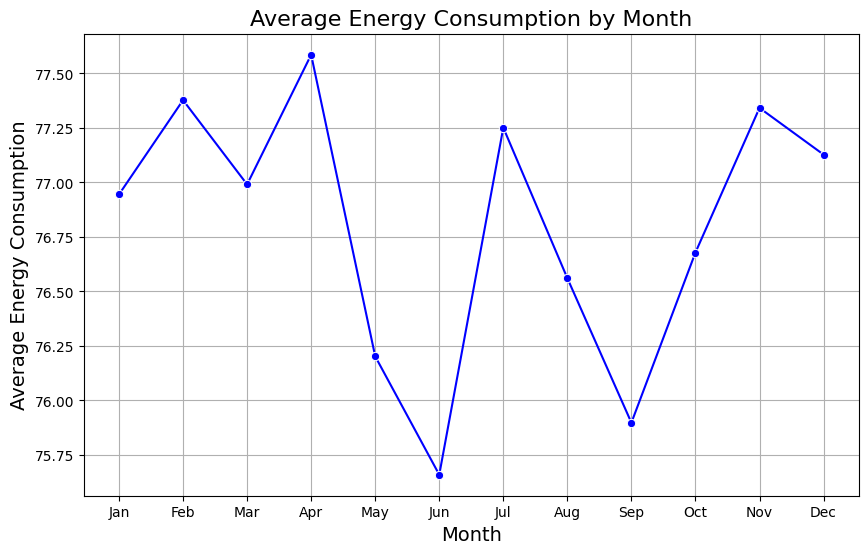

In [87]:
# Line chart
plt.figure(figsize=(10,6))
sns.lineplot(x='Month', y= 'EnergyConsumption', data = monthly_average_consumption, marker='o', color='blue')
plt.title('Average Energy Consumption by Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Energy Consumption', fontsize=14)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

The average Energy Consumption values are relatively stable across months, ranging between 75 and 79 throughout the year. 
This indicates that there isn't a significant variation in energy consumption based solely on the month.

Therefore, creating dummy variables for the month column may not add much predictive value for our model. Instead, we can either:
- Drop the Month column entirely to reduce complexity.
- Create a new column, 'Season', to capture potential patterns that could come from understanding how energy consumption may vary by season

In [88]:
# Create a new column Season
df['Season'] = df['Month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else 'Spring' if x in [3, 4, 5] else 'Summer' if x in [6, 7, 8] else 'Autumn')
# Eliminate the month column
df.drop('Month', axis=1, inplace=True)

In [89]:
df.head()

,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption,Season
0,0,Saturday,No,25.139433,43.431581,1565.693999,5,On,Off,2.774699,75.364373,Winter
1,1,Saturday,No,27.731651,54.225919,1411.064918,1,On,On,21.831384,83.401855,Winter
2,2,Saturday,No,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,78.270888,Winter
3,3,Saturday,No,20.080469,50.371637,1452.316318,1,Off,On,8.623447,56.519850,Winter
4,4,Saturday,No,23.097359,51.401421,1094.130359,9,On,Off,3.071969,70.811732,Winter


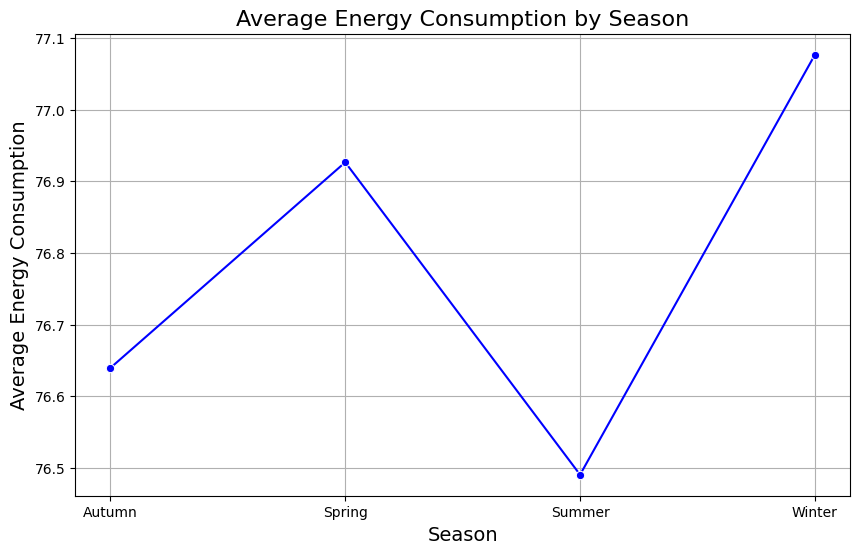

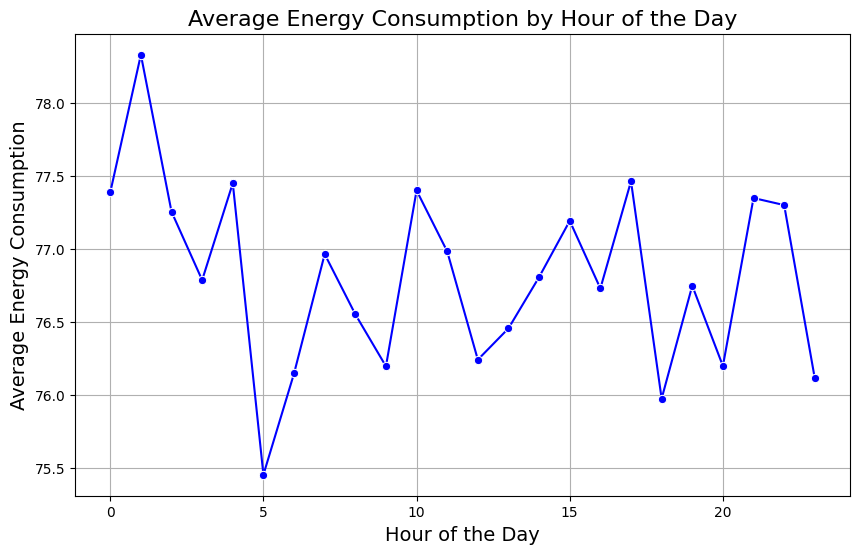

In [90]:
# line chart for energy consumption by season
seasonal_average_consumption = df.groupby('Season')['EnergyConsumption'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(x='Season', y= 'EnergyConsumption', data = seasonal_average_consumption, marker='o', color='blue')
plt.title('Average Energy Consumption by Season', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Average Energy Consumption', fontsize=14)
plt.grid(True)
plt.show()


# line chart for energy consumption by hour of the day
hour_avg_consumption = df.groupby('Hour')['EnergyConsumption'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(x='Hour', y= 'EnergyConsumption', data = hour_avg_consumption, marker='o', color='blue')
plt.title('Average Energy Consumption by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Average Energy Consumption', fontsize=14)
plt.grid(True)
plt.show()



While there are some variations in Energy Consumption throughout the day, the consumption values remain within a narrow range of 75 to 79. This suggests that energy consumption does not significantly vary with each individual hour.

If we were to create dummy variables for every single hour of the day (0 to 23), it would significantly increase the dimensionality of our data, leading to a more complex model and potentially causing issues like overfitting.

To simplify the model and capture the time-of-day effect without unnecessary complexity, we can categorize the hours into broader time periods that are likely to exhibit similar energy consumption behavior:

- Morning: 6 AM to 12 PM
- Afternoon: 12 PM to 6 PM
- Evening: 6 PM to 24 PM
- Night: 0 AM to 6 AM

By grouping the hours into these four parts of the day, we reduce the number of features, decrease the model's complexity, and still preserve meaningful insights into how energy consumption behaves across different times of the day.

In [91]:
df["TimeOfDay"] = df["Hour"].apply(lambda x: 'Morning' if 6<=x<12 else 'Afternoon' if 12<=x<18 else 'Evening' if 18<=x<24 else 'Night')
df.drop('Hour', axis=1, inplace=True)

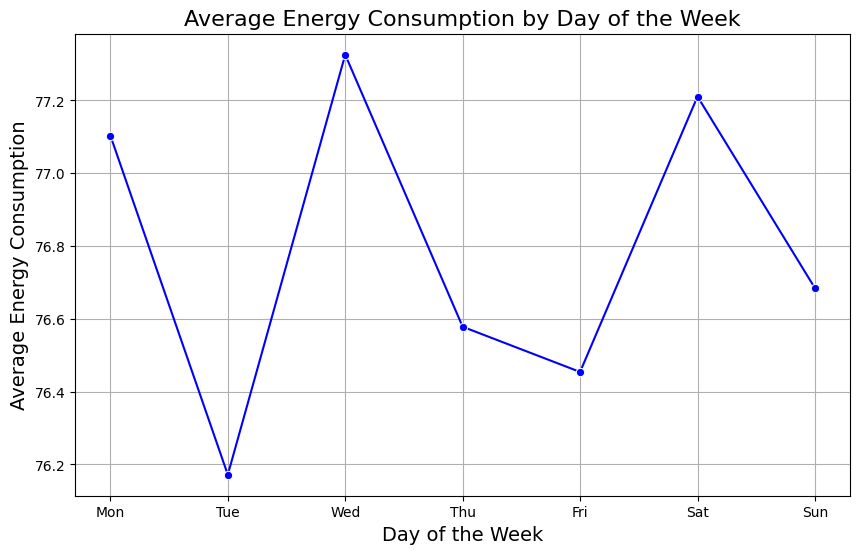

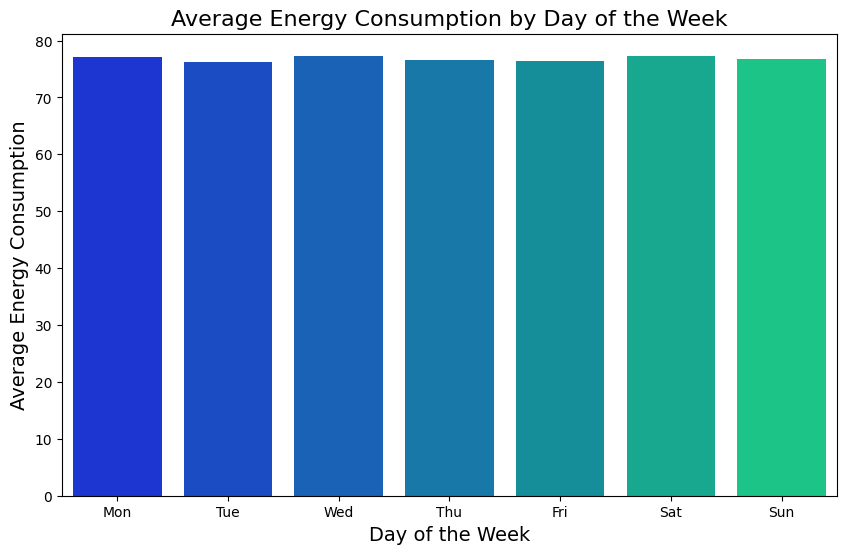

In [92]:
# line chart for energy consumption by  day of the week
day_of_week_average_consumption = df.groupby('DayOfWeek')['EnergyConsumption'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(x='DayOfWeek', y= 'EnergyConsumption', data = day_of_week_average_consumption, marker='o', color='blue')
plt.title('Average Energy Consumption by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Average Energy Consumption', fontsize=14)
plt.xticks(ticks=range(0, 7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True)
plt.show()

# bar chart for energy consumption by day of the week
plt.figure(figsize=(10,6))
sns.barplot(x='DayOfWeek', y= 'EnergyConsumption', data = day_of_week_average_consumption, palette='winter')
plt.title('Average Energy Consumption by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Average Energy Consumption', fontsize=14)
plt.xticks(ticks=range(0, 7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

The plot shows the Average Energy Consumption by DayOfWeek, and it remains relatively stable throughout the week. The energy consumption patterns do not exhibit significant variation based on the day of teh week.

The only potential change in energy consumption would likejy occur during holidays, which are captured by the Holiday column in our dataset. Since we already have a separate Holiday column to track changes in energy consumption during holidays, the DayOfWeek column does not add meaningful information to our analysis.

Therefore, it is more efficient to drop the DayOfWeek column to reduce dimensionality and keep only the relevant features that affect the model's performance. This helps to avoid unnecessary complexity and potential overfitting.

In [93]:
df.drop('DayOfWeek', axis=1, inplace=True)  

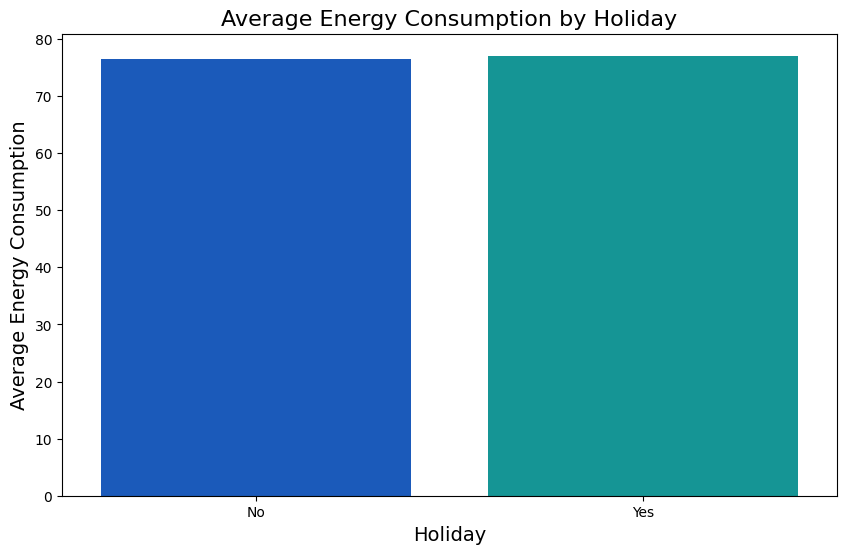

In [94]:
# plot enegy comsumption by holiday
holiday_average_consumption = df.groupby('Holiday')['EnergyConsumption'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='Holiday', y= 'EnergyConsumption', data = holiday_average_consumption, palette='winter')
plt.title('Average Energy Consumption by Holiday', fontsize=16)
plt.xlabel('Holiday', fontsize=14)
plt.ylabel('Average Energy Consumption', fontsize=14)
plt.show()


Can also see that are not a big difference in the energy consumption between holidays and non-holidays. The average energy consumption on holidays is slightly lower than on non-holidays, but the difference is not significant.

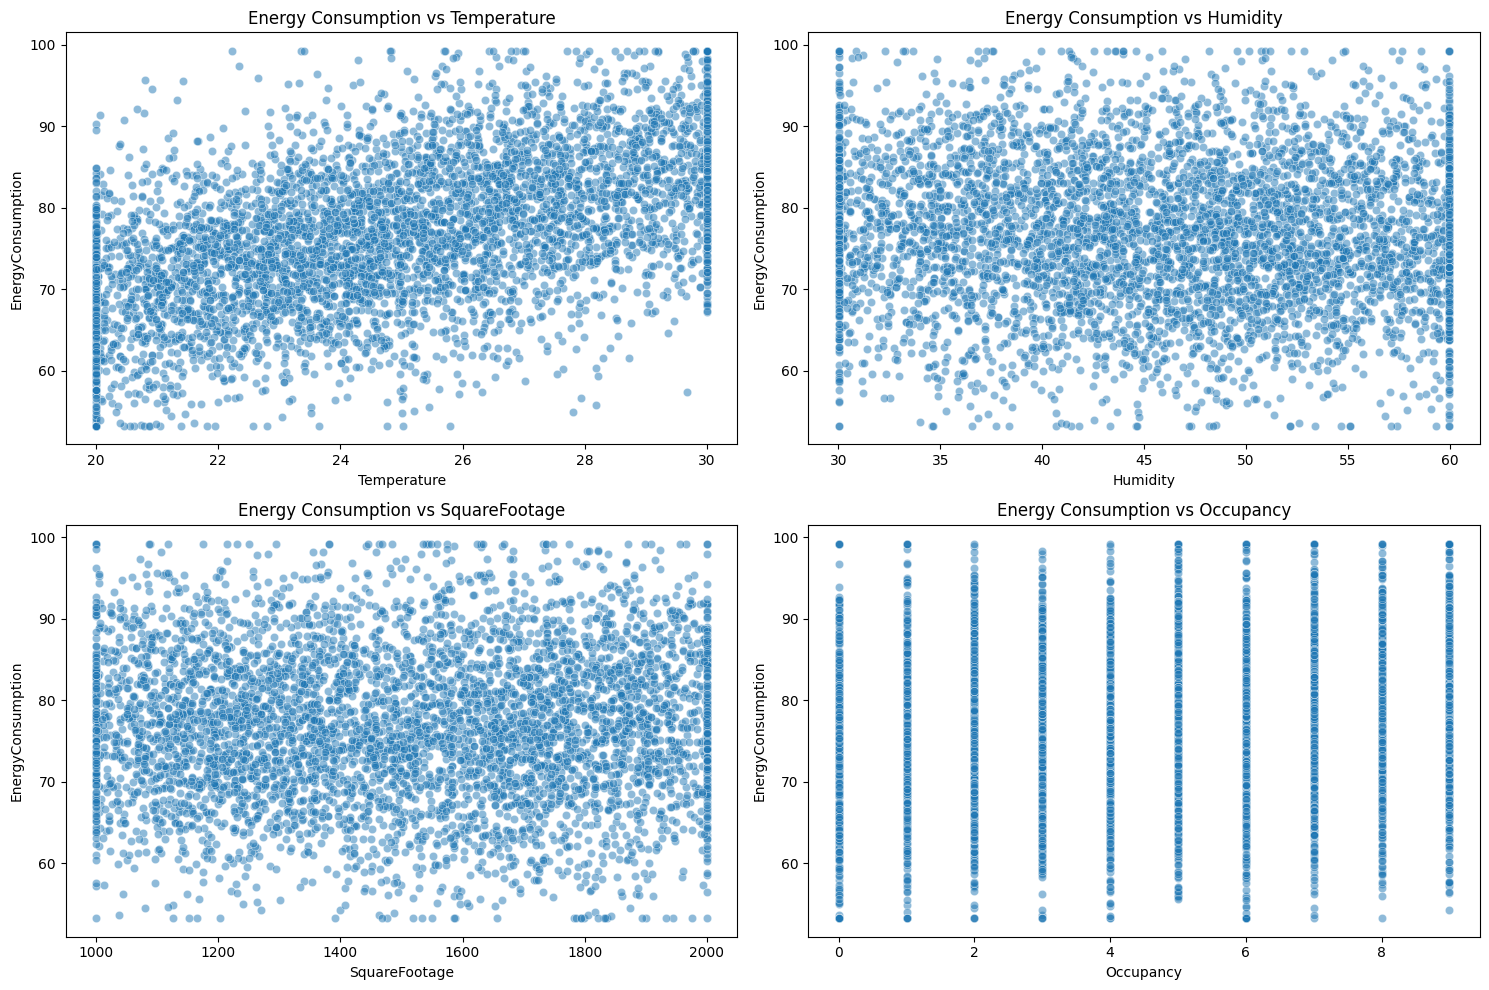

In [95]:
numerical_features = ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    sns.scatterplot(data=df, x=feature, y='EnergyConsumption', alpha=0.5, ax=axes[idx])
    axes[idx].set_title(f'Energy Consumption vs {feature}')

plt.tight_layout()
plt.show()

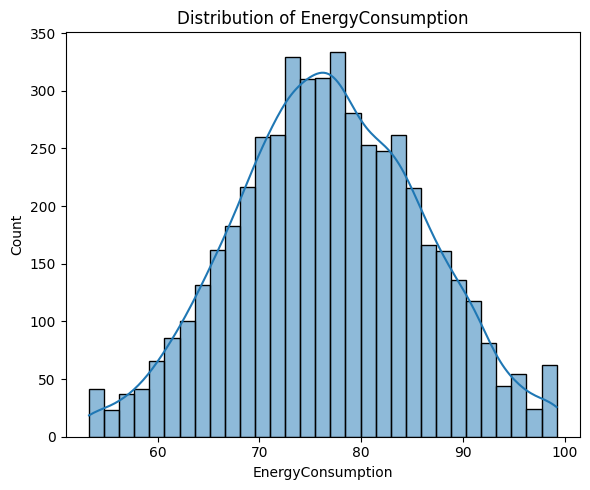

In [96]:
numerical_features = ['EnergyConsumption']

fig, axes = plt.subplots(1, len(numerical_features), figsize=(6 * len(numerical_features), 5))
if len(numerical_features) == 1:
    axes = [axes]  

for idx, feature in enumerate(numerical_features):
    sns.histplot(data=df, x=feature, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

# 2. Data Processing

In [97]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Holiday            5000 non-null   object 
 1   Temperature        5000 non-null   float64
 2   Humidity           5000 non-null   float64
 3   SquareFootage      5000 non-null   float64
 4   Occupancy          5000 non-null   int64  
 5   HVACUsage          5000 non-null   object 
 6   LightingUsage      5000 non-null   object 
 7   RenewableEnergy    5000 non-null   float64
 8   EnergyConsumption  5000 non-null   float64
 9   Season             5000 non-null   object 
 10  TimeOfDay          5000 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 429.8+ KB


,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption,Season,TimeOfDay
0,No,25.139433,43.431581,1565.693999,5,On,Off,2.774699,75.364373,Winter,Night
1,No,27.731651,54.225919,1411.064918,1,On,On,21.831384,83.401855,Winter,Night
2,No,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,78.270888,Winter,Night
3,No,20.080469,50.371637,1452.316318,1,Off,On,8.623447,56.519850,Winter,Night
4,No,23.097359,51.401421,1094.130359,9,On,Off,3.071969,70.811732,Winter,Night


In [ ]:
# Convert the categorical features to numerical using one-hot encoding
# use OneHotEncoder from sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder

# Create an instance of OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse=False)

# Fit the encoder on the categorical features
categorical_features = ['Season', 'TimeOfDay', 'Holiday', 'HVACUsage', 'LightingUsage']
encoder.fit(df[categorical_features])

df.head()


,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption,Holiday_Yes,HVACUsage_On,LightingUsage_On,Season_Spring,Season_Summer,Season_Winter,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night
0,25.139433,43.431581,1565.693999,5,2.774699,75.364373,False,True,False,False,False,True,False,False,True
1,27.731651,54.225919,1411.064918,1,21.831384,83.401855,False,True,True,False,False,True,False,False,True
2,28.704277,58.907658,1755.715009,2,6.764672,78.270888,False,False,False,False,False,True,False,False,True
3,20.080469,50.371637,1452.316318,1,8.623447,56.519850,False,False,True,False,False,True,False,False,True
4,23.097359,51.401421,1094.130359,9,3.071969,70.811732,False,True,False,False,False,True,False,False,True
